In [86]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [79]:
using Plots
using Distributed
using LinearAlgebra

num_cores = length(Sys.cpu_info())
println("num_cores = $(num_cores)")
if nprocs()==1
    addprocs(num_cores; exeflags=`--project=$(Base.active_project())`)
end

@everywhere begin
    using LatticeAlgorithms
    using LinearAlgebra
    using Dates
    using BlockDiagonals
end
using JLD2

num_cores = 96


In [80]:
type_lattice = "surface_square"

# dmin, dmax = 3, 39
# σrange = vcat(0.50:0.01:0.59, 0.591:0.001:0.607, exp(-1/2))

dmin, dmax = 21, 23
σrange = [exp(-1/2)]


drange = dmin : 2 : dmax
σdrange = []
for σ in σrange
    for d in drange
        push!(σdrange, [σ, d])
    end
end

num_samples = Int(1e7)

num_samples_each_core = Int(ceil(num_samples/num_cores))
num_total_samples = Int(num_samples_each_core * num_cores);
println([num_samples_each_core, num_samples, num_total_samples])

logfile = "bsv_$(type_lattice)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples)_log.txt"
    open(logfile, "w") do file
end

[104167, 10000000, 10000032]


In [95]:
# Note that d=23 takes 2-3 days to finish

In [ ]:
@time results = pmap(1:num_cores) do _
    p_list = Dict(σdrange.=>[0.0 for _ in 1 : length(σdrange)])
    t_list = Dict(σdrange.=>[0.0 for _ in 1 : length(σdrange)])
    
    Ms = Dict()
    Ωs = Dict()
    Mperps = Dict()
    invtransposeMqs = Dict()
    invtransposeMperps = Dict()
    transposeΩMperps = Dict()
    for (ind_σd, σd) in enumerate(σdrange)
        σ, d = σd[1], Int(σd[2])
        M = surface_code_M(d) ; 
        Mperp = GKP_logical_operator_generator(M) 
        Ω = Ω_matrix(M)         
        invtransposeMq = inv(transpose(M))[1:2:end, 1:2:end]    
        Ms[d] = M
        Mperps[d] = Mperp
        Ωs[d] = Ω
        invtransposeMqs[d] = invtransposeMq
        invtransposeMperps[d] = inv(√(2π) * transpose(Mperp))
        transposeΩMperps[d] = -transpose(Ω*Mperp)
    end        
    
    for (ind_σd, σd) in enumerate(σdrange)
        σ, d = σd[1], Int(σd[2])
        p_I_bsv = 0
        time_bsv = 0        

        σdtime = @elapsed for _ in 1 : num_samples_each_core
            ξ = σ * randn(2d^2)

            if d > 21
                setprecision(BigFloat, 64)
                ξ = BigFloat.(ξ)
            end
            
            ξ2 = -√(2π) * Ms[d] * Ωs[d] * ξ
            s = ξ2 - floor.(ξ2/(2π)) * 2π
            # ηs = -transpose(Ωs[d]*Mperps[d]) * s/√(2π) ; 
            # b = inv(√(2π) * transpose(Mperps[d])) * (ηs-ξ)
            ηs = transposeΩMperps[d] * s/√(2π) ; 
            b = invtransposeMperps[d] * (ηs-ξ)
            @assert norm(round.(Int, b) - b) < 1e-10    
            
            time_bsv += @elapsed rec_q = bsv_surface_code(ηs[1:2:end], σ; Nv=5, subspace="x")

            neterror_q = invtransposeMqs[d] * (rec_q+ξ[1:2:end]) / √(2π)                

            norm(round.(Int, neterror_q) - neterror_q) < 1e-10 ? nx = 0 : nx = 1

            if mod(nx, 2) == 0
                p_I_bsv += 1
            end
        end
        p_list[[σ, d]] += p_I_bsv
        t_list[[σ, d]] += time_bsv

        if myid() == 2 # Print the progress of the 2nd worker
            println(["$(ind_σd)/$(length(σdrange)), $d, $(σdtime), $(string(now()))"])
            open(logfile, "a") do file
                write(file, "$(ind_σd)/$(length(σdrange)), $d, $(σdtime), $(string(now()))\n")
            end
        end
    end
    
    return p_list, t_list
end ;     

t_list = merge(+, [res[2] for res in results]...) 
p_list = merge(+, [res[1] for res in results]...)


map!(v->v./num_total_samples, values(t_list))
map!(v->v./num_total_samples, values(p_list))

c_list = Dict()

for (k, v) in p_list
    px = v * (1-v)
    pz = px
    py = (1-v)^2
    c_list[k] = coherent_information_pauli_channel(px, py, pz)
end

# Save the result
fn = "bsv_$(type_lattice)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples).jld2";
jldsave(fn; 
    σrange=σrange, 
    num_samples=num_samples_each_core*num_cores,
    p_list = p_list,
    t_list = t_list,
    c_list = c_list,
    drange = drange
)

      From worker 2:	["1/2, 21, 6979.954684935, 2024-10-13T22:36:34.902"]


In [87]:
sort(load(fn)["p_list"])

OrderedCollections.OrderedDict{Vector{Float64}, Float64} with 2 entries:
  [0.606531, 21.0] => 0.842063
  [0.606531, 23.0] => 0.842113

# Compare to existing data

In [88]:
function get_p0list_sorted(p_list, drange, σrange)
    p0list_sorted = sort(p_list)
    p0list_sorted = collect(values(p0list_sorted))
    p0list_sorted = reshape(p0list_sorted, (length(drange), length(σrange)))
    p0list_sorted = [p0list_sorted[:,i] for i in 1:size(p0list_sorted,2)]
    return p0list_sorted
end


get_p0list_sorted (generic function with 1 method)

In [89]:
new_data = sort(load(fn))
new_p_list = new_data["p_list"]
new_p_list_sorted = get_p0list_sorted(new_p_list, drange, σrange)

1-element Vector{Vector{Float64}}:
 [0.8420628053990227, 0.8421131052380633]

σ = 0.606
[0.7174665109893961, 0.7142618818475609, 0.7134140532879866, 0.7130386965639965, 0.7124038712583283, 0.7122273654665092, 0.7123108908162824, 0.7123232091105227, 0.7129238973208676, 0.7129522586272073, 0.7130376385000764, 0.7135994524892532, 0.7135034907380026, 0.713849084452102, 0.714210272992031, 0.714494136739803, 0.7145633863629323, 0.7147175303382922, 0.7148638825167793]

σ = 0.6065306597126334
[0.7159243410691051, 0.7127440214524672, 0.7111788634419325, 0.7105521018681251, 0.7100948094882956, 0.7095273177350689, 0.7094216963066785, 0.7091476563198282, 0.7092918281032465, 0.7093701518614958, 0.7094902827987078, 0.7092392978938824, 0.7091248809360696, 0.7094739396970263, 0.7093070614388253, 0.7094000426578225, 0.7094426229523773, 0.709152504399512, 0.7092728740988792]

σ = 0.607
[0.7144895079033063, 0.7114654018047878, 0.7097614440452391, 0.7084074896111618, 0.7074117901549436, 0.7071091314035367, 0.7063448701822087, 0.7063100873901674, 0.70626001511619, 0.7058485823506406

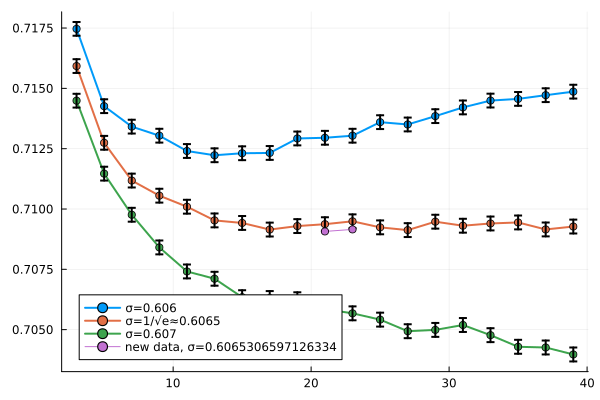

In [90]:
data_surf_sq = load("data/bsv_surface_square_3_39_10016000.jld2")


σrange_threshold = [0.606, exp(-1/2), 0.607]
drange_threshold = data_surf_sq["drange"][2:end] # exclude d = 1
p_list_threshold = Dict()
for d in drange_threshold
    for σ in σrange_threshold
        p_list_threshold[[σ, d]] = data_surf_sq["p_list"][[σ, d]]
    end
end

sorted_p_list_threshold = get_p0list_sorted(
    p_list_threshold,
    drange_threshold,
    σrange_threshold,
)

plot()
num_samples = 1e7
for (ind, σ) in enumerate(σrange_threshold)
    ind!=2 ? label="σ=$σ" : label="σ=1/√e≈0.6065"

    println("σ = $σ")
    println(sorted_p_list_threshold[ind].^2)
    println()
    fidelity = sorted_p_list_threshold[ind].^2
    yerr = 2 .* sqrt.(fidelity .* (1 .- fidelity) / num_samples)
    plot!(drange_threshold, fidelity, yerr=yerr, marker=:circle, label=label, linewidth=2)
end

for (σind, σ) in enumerate(σrange)
    plot!(drange, new_p_list_sorted[σind].^2, marker=:circle, label="new data, σ=$σ")
end
plot!(legend=:bottomleft)